In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib.pylab as plt
from sklearn.metrics import roc_curve, roc_auc_score, recall_score
from tensorflow.keras.applications import InceptionResNetV2, ResNet50, InceptionV3, DenseNet121, Xception
import tensorflow_hub as hub

2023-04-25 21:34:21.668845: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 21:34:23.022558: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#set tensorflow to use CPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
img_size = 512
batch_size = 16
num_classes = 1
train_dir = '../data/oob/train'
test_dir = '../data/oob/test'
def get_ds():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, label_mode='binary', shuffle=False, image_size=(img_size, img_size), batch_size=batch_size, validation_split=0.2, subset='training')
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, label_mode='binary', shuffle=False, image_size=(img_size, img_size), batch_size=batch_size, validation_split=0.2, subset='validation')
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir, label_mode='binary', shuffle=False, image_size=(img_size, img_size), batch_size=batch_size)
    #Apply data augmentation
    preprocessing_model = tf.keras.Sequential()
    preprocessing_model.add(
        tf.keras.layers.experimental.preprocessing.RandomRotation(40))
    preprocessing_model.add(
        tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2))
    preprocessing_model.add(
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2, 0.2))
    preprocessing_model.add(
        tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal"))
    preprocessing_model.add(
        tf.keras.layers.experimental.preprocessing.RandomFlip(mode="vertical"))

    train_ds = train_ds.map(lambda images, labels:
                            (preprocessing_model(images), labels))
    
    #prefetch datasets
    train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    val_ds = val_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    test_ds = test_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return train_ds, val_ds, test_ds

In [4]:
n_layers = 2
n_neurons = 512
n_dropout = 0.2
def get_model():
    base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))
    preprocess_fx = tf.keras.applications.xception.preprocess_input
    
    inputs = tf.keras.Input(shape=(img_size, img_size, 3))
    y = preprocess_fx(inputs)
    y = base_model(y, training=True)
    y = tf.keras.layers.GlobalAveragePooling2D()(y)
    y = tf.keras.layers.Dropout(n_dropout)(y)
    y = tf.keras.layers.Dense(n_neurons, activation='relu')(y)
    y = tf.keras.layers.Dropout(n_dropout)(y)
    outputs = tf.keras.layers.Dense(num_classes, activation='sigmoid')(y)
    model = tf.keras.Model(inputs, outputs)
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=3e-4),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])
    #set the base model to be trainable
    base_model.trainable = True
    return model


In [5]:
early_stopping = keras.callbacks.EarlyStopping(patience=15, min_delta=1e-6, restore_best_weights=True)

In [6]:
# strategy = tf.distribute.MirroredStrategy()
# print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
# with strategy.scope():
model = get_model()
train_ds, val_ds, test_ds = get_ds()

2023-04-25 21:34:28.448785: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18237 MB memory:  -> device: 0, name: NVIDIA RTX A4500, pci bus id: 0000:81:00.0, compute capability: 8.6
2023-04-25 21:34:28.449677: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10362 MB memory:  -> device: 1, name: NVIDIA TITAN V, pci bus id: 0000:02:00.0, compute capability: 7.0


Found 6468 files belonging to 2 classes.
Using 5175 files for training.
Found 6468 files belonging to 2 classes.
Using 1293 files for validation.
Found 1835 files belonging to 2 classes.


In [7]:
#find the proportion of each class in the training set
oob_count = []
noob_count = []
oob_count = os.listdir('../data/oob/train/1')
noob_count = os.listdir('../data/oob/train/0')
print('Number of OOB images: ', len(oob_count))
print('Number of NOOB images: ', len(noob_count))
print('Proportion of OOB images: ', len(oob_count)/(len(oob_count)+len(noob_count)))

Number of OOB images:  1069
Number of NOOB images:  5399
Proportion of OOB images:  0.1652752009894867


In [8]:
#show a batch of images with label 1 (OOB)
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        if labels[i][0] == 1:
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(str(labels[i][0]))
            plt.axis("off")

2023-04-25 21:34:33.357696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5175]
	 [[{{node Placeholder/_4}}]]
2023-04-25 21:34:33.358478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_16' with dtype resource
	 [[{{node Placeholder/_16}}]]


<Figure size 1000x1000 with 0 Axes>

In [9]:
epochs = 500
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stopping])

2023-04-25 21:34:35.762505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_16' with dtype resource
	 [[{{node Placeholder/_16}}]]
2023-04-25 21:34:35.763379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_17' with dtype resource
	 [[{{node Placeholder/_17}}]]


Epoch 1/500


2023-04-25 21:34:53.429553: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-04-25 21:34:58.550234: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-25 21:34:58.556174: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x62d1c610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-25 21:34:58.556217: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA RTX A4500, Compute Capability 8.6
2023-04-25 21:34:58.556232: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (1): NVIDIA TITAN V, Compute Capability 7.0
2023-04-25 21:34:58.569312: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-25 21:34:58.809956: I .

324/324 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 0.9996

2023-04-25 21:45:33.438968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1293]
	 [[{{node Placeholder/_4}}]]
2023-04-25 21:45:33.439715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1293]
	 [[{{node Placeholder/_4}}]]


324/324 [==============================] - 672s 2s/step - loss: 0.0033 - accuracy: 0.9996 - val_loss: 12.9535 - val_accuracy: 0.1732
Epoch 2/500
324/324 [==============================] - 594s 2s/step - loss: 9.6951e-07 - accuracy: 1.0000 - val_loss: 14.4016 - val_accuracy: 0.1732
Epoch 3/500
324/324 [==============================] - 594s 2s/step - loss: 2.1006e-07 - accuracy: 1.0000 - val_loss: 15.1159 - val_accuracy: 0.1732
Epoch 4/500
324/324 [==============================] - 593s 2s/step - loss: 1.3123e-07 - accuracy: 1.0000 - val_loss: 15.7877 - val_accuracy: 0.1732
Epoch 5/500
324/324 [==============================] - 596s 2s/step - loss: 7.9539e-08 - accuracy: 1.0000 - val_loss: 16.3566 - val_accuracy: 0.1732
Epoch 6/500
324/324 [==============================] - 595s 2s/step - loss: 4.8018e-08 - accuracy: 1.0000 - val_loss: 16.8136 - val_accuracy: 0.1732
Epoch 7/500
324/324 [==============================] - 592s 2s/step - loss: 4.1592e-08 - accuracy: 1.0000 - val_loss: 17.2

In [10]:
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score
y_preds = {}
y_trues = {}
for i in range(num_classes):
    y_preds[i] = np.array([])
    y_trues[i] = np.array([])
for images, labels in test_ds:
    pred = model.predict(images)
    for i in range(1):
        y_preds[i] = np.concatenate((y_preds[i], pred[:, i]))
        y_trues[i] = np.concatenate((y_trues[i], labels[:, i]))

2023-04-26 00:14:16.731077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1835]
	 [[{{node Placeholder/_4}}]]
2023-04-26 00:14:16.731542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1835]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 495ms/step


In [11]:
class_strs = ['oob']

In [12]:
results_df = pd.DataFrame(columns=['class', 'auc', 'accuracy'])
for i in range(1):
    auc = roc_auc_score(y_trues[i], y_preds[i])
    acc = accuracy_score(y_trues[i], y_preds[i] > 0.5)
    results_df.loc[i] = [class_strs[i], auc, acc]
results_df

,class,auc,accuracy
0,oob,0.664211,0.982016


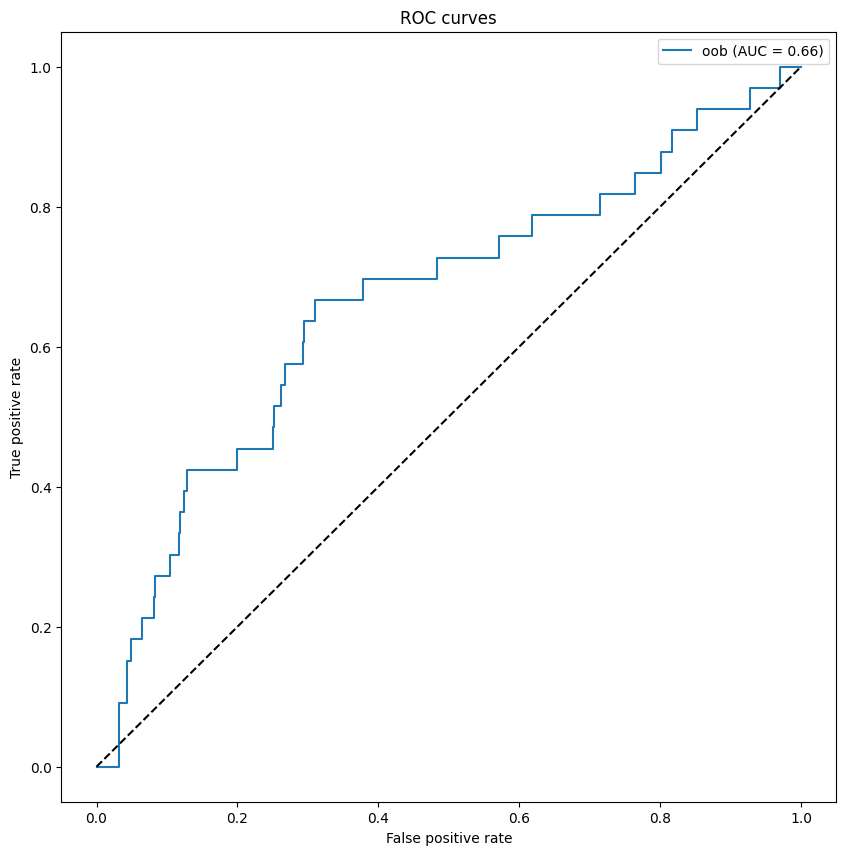

In [13]:
#plot the ROC curves for each class using the y_preds and y_trues dictionaries
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10, 10))
for i in range(1):
    fpr, tpr, _ = roc_curve(y_trues[i], y_preds[i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{} (AUC = {:.2f})'.format(class_strs[i], roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves')
plt.legend(loc='best')
plt.savefig('../results/oob_roc_curves.png')

In [ ]:
file_paths = test_ds.file_paths

In [ ]:
#get predictions for each image and save to csv
class_strs.append('image_fname', 'label')
preds_df = pd.DataFrame(columns=class_strs)

In [ ]:
for image in test_ds:
    pred = model.predict(image)
    pred = pred[0]
    pred = np.append(pred, os.path.basename(file_paths[0]))
    pred = np.append(pred, os.path.basename(os.path.dirname(file_paths[0])))
    preds_df.loc[len(preds_df)] = pred
    file_paths = file_paths[1:]

2023-01-18 16:56:59.331721: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_116997"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:960"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. 

In [ ]:
preds_df.head()

,oob,other,phase_1_exposure,phase_2_hiatal_dissec,phase_3_fundus,phase_4_eso,phase_5_hiatal_repair,phase_6_wrap,image_fname
0,0.0145383645,0.88687944,0.018921277,0.023483107,0.011018063,0.020968148,0.010109716,0.014081824,vid_1_3565.jpg
1,1.9744988e-05,0.0033628787,2.005741e-06,3.8803457e-05,6.1614423e-06,6.8650356e-06,0.0034440015,0.9931195,vid_1_4860.jpg
2,0.0025292393,0.724156,0.0009202642,0.004356111,0.0015864857,0.0086976485,0.09305355,0.16470067,vid_1_865.jpg
3,0.055614695,0.7358492,0.07810252,0.053913485,0.011321764,0.05913351,0.0037437472,0.0023211276,vid_1_2300.jpg
4,0.016452251,0.7833865,0.014081486,0.029732594,0.01963642,0.024813775,0.02353263,0.08836426,vid_1_2465.jpg


In [ ]:
preds_df.to_csv('../data/test/preds.csv')